## Let's Raise the *Roof!* Predicting the Energy of House Music.

**Introduction**  

Spotify is one of the largest music streaming services with over [406 million users](https://www.google.com/url?q=https://newsroom.spotify.com/company-info/&sa=D&source=docs&ust=1646548657733947&usg=AOvVaw2-aNiFTZDrkhXIWRxPE4aU) amounting to [75 million monthly listeners](https://dl.acm.org/doi/10.1145/2959100.2959120). The success of Spotify can in be attributed towards the collection of user data, which allows for the curation of personalized playlists and recommended songs. Spotify has created a web API for public use, which grants users the ability to view information about artists and their songs. Amongst these functions, audio features can be gathered from songs, revealing several measures of their melody and lyrics.

For this exploration, the focus will be on songs from the [house music genre](https://www.allmusic.com/subgenre/house-ma0000002651?1646545415388&fbclid=IwAR2ZKQ2EAzLFX4E4FsCyNbLL17Y2Jrjmtqz0tW7dsIwkIn40YQT2QV1hYH8), which is a type of electronic dance music characterized by high energy, repeated beats, and synthesized sounds. As such, the purpose of this project is to create a predictive model for the energy rating for house music songs based on the other audio features, including acousticness, danceability, energy, liveness, loudness, speechiness, tempo, and valence.

For the dataset, the [Spotify web API](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) will be used to collect audio features for all the songs of the top 10 artists in the house music genre (Tiesto, Mashmello, Calvin Harris, The Chainsmokers, Alan Walker, Kygo, Diplo, Daft Punk, Martin Garrix, and Zedd). Collecting the audio features of their tracks provides us with several song metrics, of which we will be focusing on acousticness (not having electric amplification), danceability (suitability for dancing), energy (intensity and activity), liveness (presence of audience), loudness (sound amplitude), speechiness (presence of spoken words), tempo (pace), and valence (a measure of positivity).

**Preliminary Exploratory Data Analysis**

In [2]:
# loading required libraries
library(spotifyr)
library(tidyverse)
library(dplyr)
library(infer)
library(ggplot2)
library(GGally)
library(cowplot)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [63]:
# accessing the Spotify API
Sys.setenv(SPOTIFY_CLIENT_ID = '8dc35601d48d4a9cbfc49ac777956669')
Sys.setenv(SPOTIFY_CLIENT_SECRET = 'b214be57f4bb42d79064f69cb20fdce9')
access_token <- get_spotify_access_token()

# list of top artists of genre: house
top_artists <- get_genre_artists("house") %>%
    arrange(desc(popularity))

# converting id column from dataframe into vector
id_list <- as.vector(top_artists[[3]], mode = "character")

# initiating dataframe accumulator
# Travis Scott is NOT a house artist!!
raw <- get_artist_audio_features(id_list[2])

# looping over top 10 artists of genre to accumulate data
i <- 3
while (i < 12) {
  temp <- get_artist_audio_features(id_list[i])
  raw <- rbind(raw, temp)
  i <- i + 1
}

# writing to local and uploading to cloud
write_csv(raw, "data/top_10_house_artists_data.csv")

In [3]:
# reading from cloud and previewing the data
house_raw <- read_csv("https://drive.google.com/uc?id=1B5C4YbVU0cFlrbUWhir9lqwxbwYBlou_&export=download", show_col_types = FALSE)         #nolint
head(house_raw)
nrow(house_raw)

artist_name,artist_id,album_id,album_type,album_images,album_release_date,album_release_year,album_release_date_precision,danceability,energy,...,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode
<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,...,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.773,0.747,...,God Is A Dancer,NA,1,track,spotify:track:6mIrY9axk9DkBCk4eHXL6c,https://open.spotify.com/track/6mIrY9axk9DkBCk4eHXL6c,The London Sessions,C#,minor,C# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.732,0.847,...,Nothing Really Matters,NA,2,track,spotify:track:39TATbzOKDwiWdrmuQBLGK,https://open.spotify.com/track/39TATbzOKDwiWdrmuQBLGK,The London Sessions,F,minor,F minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.734,0.855,...,Ride,NA,3,track,spotify:track:6GpoUPegO1TBbZCoE7FxZ7,https://open.spotify.com/track/6GpoUPegO1TBbZCoE7FxZ7,The London Sessions,B,major,B major
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.647,0.726,...,Ritual,NA,4,track,spotify:track:0teJO13Uua0AamcZ681qOd,https://open.spotify.com/track/0teJO13Uua0AamcZ681qOd,The London Sessions,D#,minor,D# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.747,0.833,...,Jackie Chan,NA,5,track,spotify:track:4vvnuJlgBeNVwq3TNmLMNX,https://open.spotify.com/track/4vvnuJlgBeNVwq3TNmLMNX,The London Sessions,D#,minor,D# minor
Tiësto,2o5jDhtHVPhrJdv3cEQ99Z,6CIslPQSknp875cigkhKJC,album,NA,2020-05-15,2020,day,0.762,0.797,...,Lifestyle,NA,6,track,spotify:track:2etmWkDzfNe7wEsb1UaBrp,https://open.spotify.com/track/2etmWkDzfNe7wEsb1UaBrp,The London Sessions,A,minor,A minor


[1] 3023

Table 1. Raw training data from the cloud.

In this dataset, there are 3023 rows, each representing a different track. There are 39 columns, with artist details (such as name, album, urls, dates), and audio features (such as energy, loudness, tempo). For this exploration, only specific audio features with continuous data is going to be examined.  
  
Thus, the next step is to clean and wrangle the dataset. It should be noted that there is a high likelihood that there are duplicate rows, where tracks were reuploaded under different names. This may be due to covers, features, or differences between singles and album songs.

In [4]:
# selecting only the important audio features
house_raw_selected <- house_raw  %>%
    select(acousticness,
           danceability,
           liveness,
           loudness,
           speechiness,
           tempo,
           valence,
           energy)

# removing duplicate rows and any NA rows
house_raw_unique <- house_raw_selected[!duplicated(house_raw_selected), ] %>%
    na.omit()

# showing tidy data
house_tidy <- house_raw_unique
head(house_tidy)
nrow(house_tidy)

acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02410,0.773,0.3420,-3.908,0.0820,119.962,0.833,0.747
0.00491,0.732,0.2810,-4.255,0.0426,123.023,0.697,0.847
0.03970,0.734,0.1050,-4.438,0.0412,117.009,0.223,0.855
0.15700,0.647,0.0844,-4.389,0.0552,114.998,0.769,0.726
0.37400,0.747,0.0586,-2.867,0.0450,128.008,0.687,0.833
0.15300,0.762,0.0931,-7.323,0.0680,127.968,0.303,0.797


[1] 2404

Table 2. Tidy data from the dataset, including audio features of acousticness, danceability, energy, liveness, loudness, speechiness, tempo, and valence. There are now a total of 2404 rows, each of them now representing a unique track.
  
Before proceeding to create the regression model, the dataset will be split into training data and testing data. To improve the external validity of the data, it will be randomly sampled from the gathered tracks in the dataset.

In [5]:
# setting seed so random results can be reproduced
set.seed(604)

# taking a random sample half the size of the dataset for training
house_train <- house_tidy %>%
    rep_sample_n(size = nrow(house_tidy) / 2, reps = 1, replace = FALSE) %>%
    ungroup() %>%
    select(-replicate)
head(house_train)
nrow(house_train)

# remaining dataset will be used for testing
house_test <- anti_join(house_tidy, house_train)
head(house_test)
nrow(house_test)

acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.54e-05,0.423,0.3610,-9.145,0.0414,101.988,0.0455,0.823
7.00e-03,0.630,0.2670,-5.575,0.0343,117.988,0.7320,0.933
4.21e-02,0.844,0.6080,-3.084,0.2350,107.983,0.3890,0.932
1.46e-03,0.705,0.0986,-8.244,0.0493,135.999,0.3870,0.944
2.07e-03,0.685,0.4970,-4.727,0.1880,100.132,0.7010,0.804
8.27e-01,0.575,0.0819,-11.993,0.0269,70.866,0.1740,0.348


[1] 1202

Joining, by = c("acousticness", "danceability", "liveness", "loudness", "speechiness", "tempo", "valence", "energy")



acousticness,danceability,liveness,loudness,speechiness,tempo,valence,energy
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00491,0.732,0.2810,-4.255,0.0426,123.023,0.697,0.847
0.02640,0.654,0.3180,-7.023,0.0430,122.046,0.649,0.849
0.18900,0.704,0.2280,-5.610,0.1780,123.028,0.576,0.899
0.17800,0.710,0.0800,-4.699,0.0339,127.969,0.504,0.742
0.33900,0.742,0.0595,-2.758,0.0476,128.022,0.694,0.838
0.00756,0.663,0.2910,-3.297,0.0556,122.986,0.408,0.950


[1] 1202

Table 3. (Above) Tidy training data, with 1202 rows, each representing a unique track.  
Table 4. (Below) Tidy testing data, with 1202 rows, each representing a unique track.  
  
Next, the data will be visualized with a scatterplot matrix, where collinearity as well as response variable correlation can be assessed. Predictor variables with strong inter-correlations indicate collinearity, which should be avoided to mitigate predictive amplification. Predictor variables with strong correlations to the response variable should be prioritized, as they can be used to build a stronger predictive model.

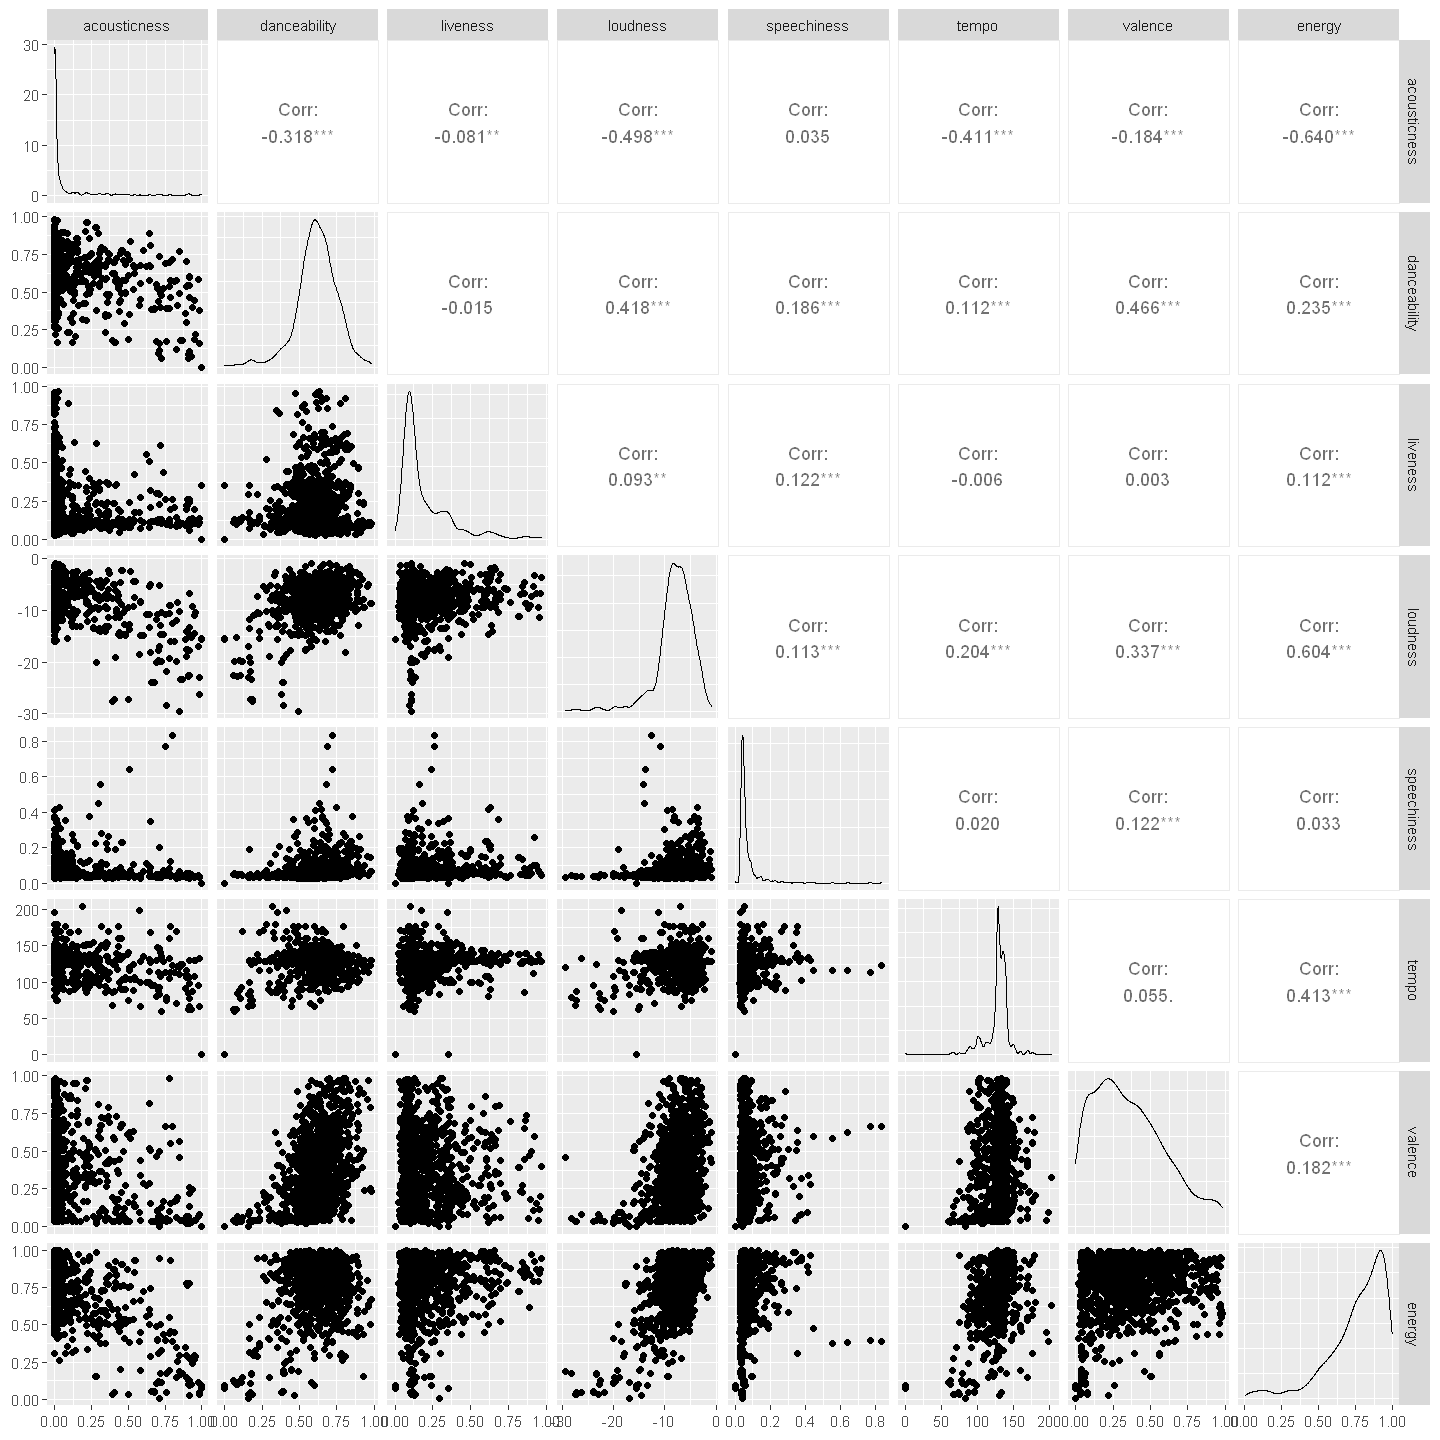

In [6]:
# increasing grid space
options(repr.plot.width = 12, repr.plot.height = 12)

# visualizing data in ggpairs
house_paired <- house_train %>%
    ggpairs()
house_paired

Figure 1. Scatterplot matrix of audio features with their Pearson correlation coefficients. The audio features included are acousticness, danceability, liveness, loudness, speechiness, tempo, valence, and energy.  
  
The 3 predictor variables with the strongest correlations to energy are acousticness (-0.640), loudness (0.604), and tempo (0.413). They can be visualized individually below.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



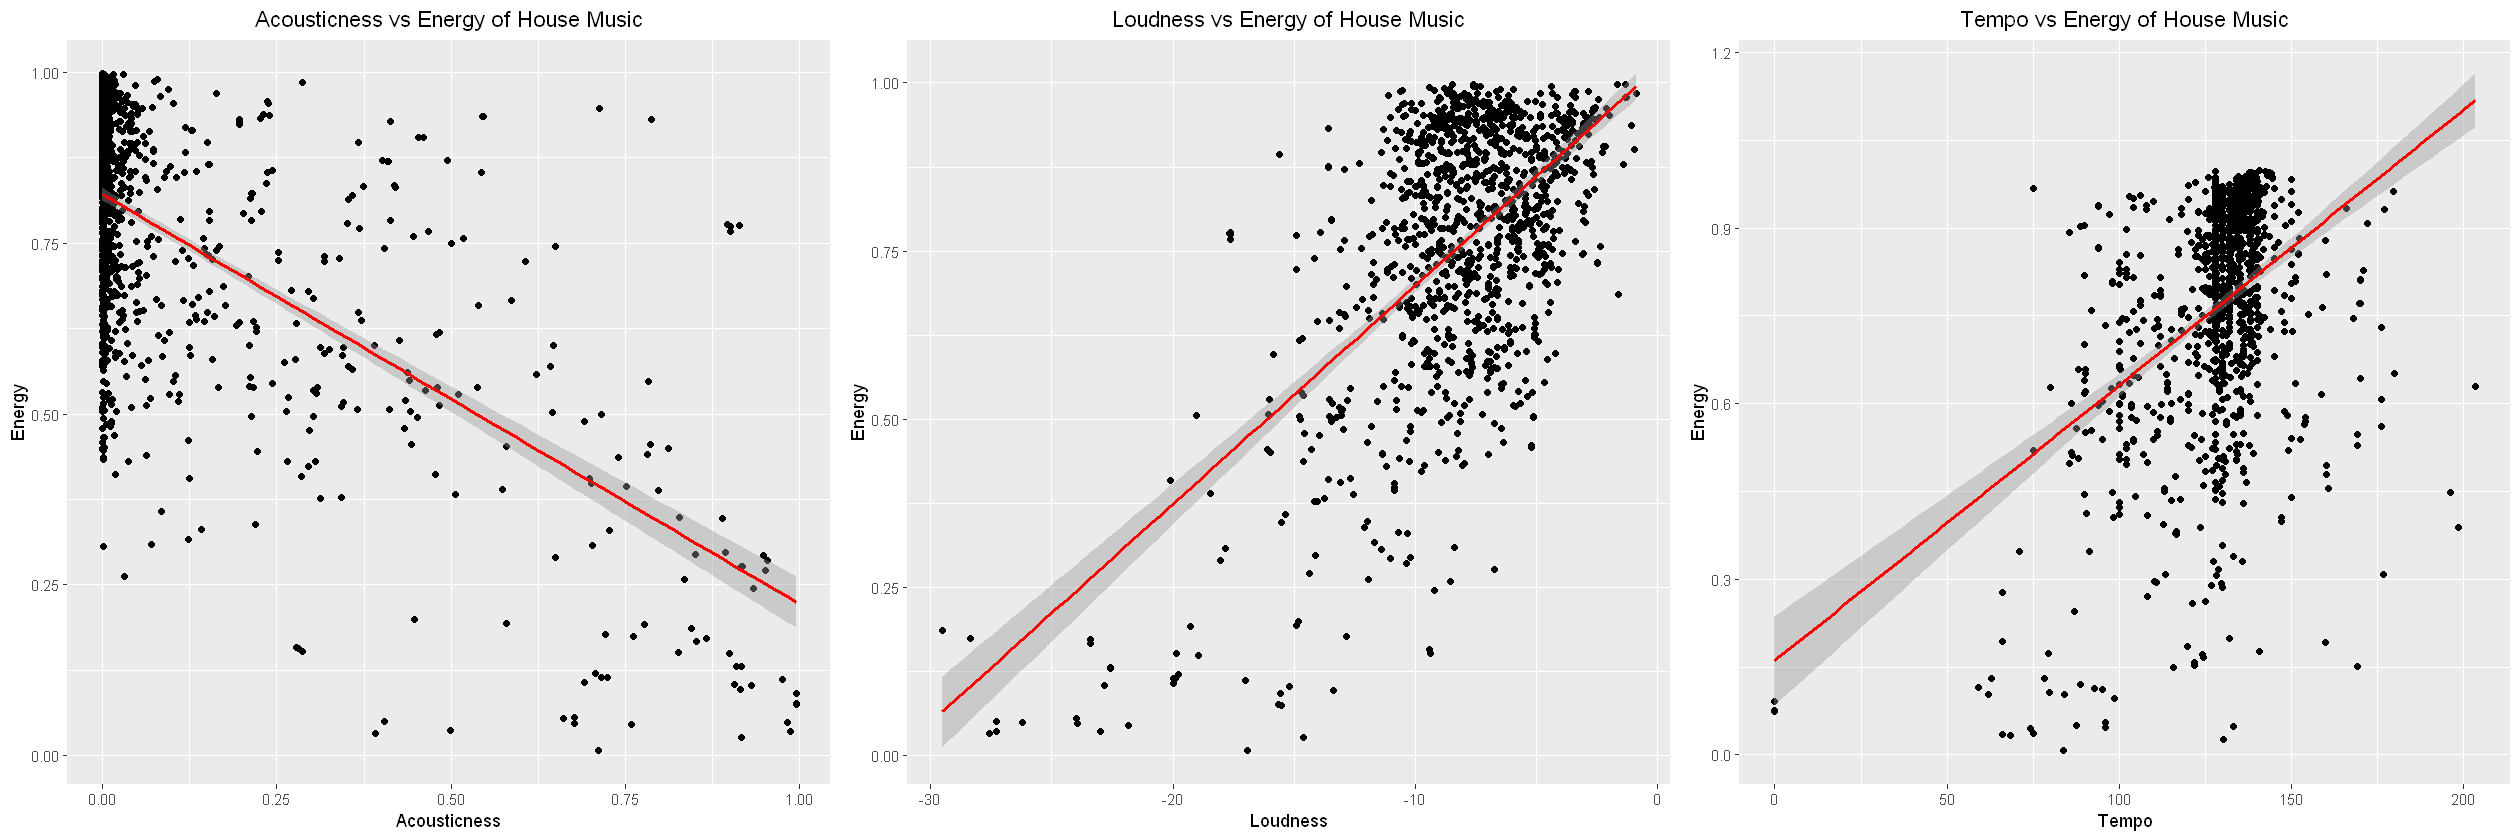

In [7]:
# increasing grid space
options(repr.plot.width = 21, repr.plot.height = 7)

# acousticness vs energy
a <- ggplot(house_train, aes(x = acousticness, y = energy)) +
    geom_point() +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Acousticness vs Energy of House Music",
         x = "Acousticness",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5))

# loudness vs energy
b <- ggplot(house_train, aes(x = loudness, y = energy)) +
    geom_point() +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Loudness vs Energy of House Music",
         x = "Loudness",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5))
    
# tempo vs energy
c <- ggplot(house_train, aes(x = tempo, y = energy)) +
    geom_point() +
    stat_smooth(method = "lm", col = "red") +
    labs(title = "Tempo vs Energy of House Music",
         x = "Tempo",
         y = "Energy") +
    theme(plot.title = element_text(hjust = 0.5))

# visualizing them side by side
plot_grid(a, b, c, nrow = 1, ncol = 3)


Figure 2.1 (Left) Acousticness vs Energy of House Music  
Figure 2.2 (Middle) Loudness vs Energy of House Music  
Figure 2.3 (Right) Tempo vs Energy of House Music

**Methods**  
  
From the exploratory analysis, the focus will be on the predictor variables of loudness, tempo, and acousticness, and the response variable will be the energy rating. In the report, a multivariate linear regressive model will be generated to predict the energy rating based off of 1-3 predictor variables. The model curve can be plotted against each predictor variable separately for individual visualization. The accuracy of the regressive model can be assessed through a root-mean-squared-error (RMSE) plot to visualize the differences between predicted values and observed values in the testing dataset. A residuals plot can also be generated to assess whether the errors are indeed independent, symmetrical, and normally distributed. 

**Expected Outcomes and Significance**  
  
Evident from the scatterplot matrix, the response variable of the energy rating appears to have a moderate to moderately-week correlations with acousticness, loudness, and tempo. After creating the model, we are expecting to find that the energy rating will be moderately associated with one or multiple of those predictor variables, and that given the measures of the predictor variables, an expected value can be generated for the energy rating with some degree of accuracy.  
  
This predictive model can be generalized to help recommend songs with high energy to consumers within the house music genre. In analyzing the data, the variables with stronger correlations to energy may help provide a framework in predicting ratings of other genres as well. Additionally, finding these insights between audio metrics is useful for artists and [emerging music creation AIs](https://www.frontiersin.org/articles/10.3389/frobt.2021.647028/full) for construction of more songs within the house music genre. These findings could also lead to further exploration of audio metrics in a more abstract scope, such as researching the energy levels and correlations in other genres, and how they compare to house music.

**References**  

https://www.google.com/url?q=https://newsroom.spotify.com/company-info/&sa=D&source=docs&ust=1646548657733947&usg=AOvVaw2-aNiFTZDrkhXIWRxPE4aU  
  
https://dl.acm.org/doi/10.1145/2959100.2959120  
  
https://www.allmusic.com/subgenre/house-ma0000002651?1646545415388&fbclid=IwAR2ZKQ2EAzLFX4E4FsCyNbLL17Y2Jrjmtqz0tW7dsIwkIn40YQT2QV1hYH8  
  
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features
  
https://www.frontiersin.org/articles/10.3389/frobt.2021.647028/full